In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers import Embedding, Dense, Lambda
from keras.regularizers import l2

from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import load_model

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [8]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_macro, f1_micro 
from src.load_data import load_data

### Load Data

In [9]:
n_tags = 2

In [10]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [11]:
def split_data(data_, to_categorize):
    
    X = np.array([sentence['sentence'].replace('\n', '').strip() 
                  for article in data_ 
                  for sentence in article['sentences']])

    y = np.array([sentence['label'] 
                  for article in data_
                  for sentence in article['sentences']])

    if to_categorize:
        y = to_categorical(y)
    
    return X, y

In [12]:
X_tra, y_tra = split_data(train_data, True)
X_val, y_val = split_data(valid_data, True)
X_test, y_test = split_data(test_data, False)

### Load ELMo

In [13]:
sess = tf.Session()
K.set_session(sess)

In [14]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [15]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [16]:
def build_flat_model_0():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(512, activation='relu')(embedding)
    dense = Dense(256, activation='relu')(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_1():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(256, activation='relu')(embedding)
    dense = Dense(128, activation='relu')(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_2():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_3():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_4():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_5():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_6():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

In [17]:
learningrate=0.0005
optimizer = Adam(lr=learningrate)
optimizer_str = 'Adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [18]:
model_name = 'RQ1_elmo_flat_model_1_' + optimizer_str + '_lr_' + str(learningrate) + '_loss_' + loss # + '_with_learnin_rate_reduction'
model = build_flat_model_0()
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

W0901 21:52:56.579989 140179328340096 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 21:52:56.580744 140179328340096 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 21:52:56.858520 140179328340096 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 21:52:56.881747 140179328340096 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/optimizers.py:790: T

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 656,642
Trainable params: 656,642
Non-trainable params: 0
_________________________________________________________________


### Train

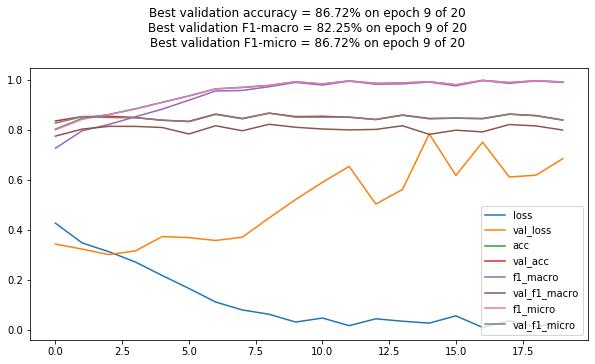

In [19]:
## Flat Model Fit
model.fit(X_tra, y_tra, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[PlotCurves(model_name=model_name)
#                      , learning_rate_reduction
                    ])

## Load the best Model

In [20]:
best_model = load_model('Model/' + model_name + '/' + model_name + '_best_f1_macro_model.h5', custom_objects={'elmo': elmo, 'tf': tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Validation Set


In [21]:
import os
model_name

'RQ1_elmo_flat_model_1_Adam_lr_0.0005_loss_binary_crossentropy'

In [22]:
results_file = os.path.join('Model/' + model_name, 'model_results_file.txt')
        
with open(results_file, 'w') as f:
    f.write('\n----------------\n')

In [23]:
y_val_true = np.array([sentence['label'] for article in valid_data 
                                 for sentence in article['sentences']])

y_val_preds = best_model.predict(X_val, batch_size=32)
y_val_preds = np.argmax(y_val_preds, axis=1)

print(classification_report(y_val_true, y_val_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_val_true, y_val_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       269
           1       0.82      0.75      0.79       130

   micro avg       0.87      0.87      0.87       399
   macro avg       0.85      0.84      0.85       399
weighted avg       0.87      0.87      0.87       399



In [24]:
scikit_f1_score(y_val_true, y_val_preds,average='macro')

0.8453047161322886

### Test

In [25]:
y_preds = best_model.predict(X_test, batch_size=32)
y_preds = np.argmax(y_preds, axis=1)

In [26]:
### build_flat_model_1 results
print(classification_report(y_test, y_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_test, y_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       325
           1       0.82      0.51      0.63       116

   micro avg       0.84      0.84      0.84       441
   macro avg       0.83      0.73      0.76       441
weighted avg       0.84      0.84      0.83       441



In [27]:
scikit_f1_score(y_test, y_preds,average='macro')

0.763397510576982